### ESBM for recommender systems

LAST FULL FUN 23/04 9:20

In [1]:
#!uv pip install -q --system numba-cuda==0.4.0

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from collections import Counter
from collections import OrderedDict
from scipy.special import gamma
import scipy.special as sc
import numba as nb
from scipy.special import gammaln
import time
import seaborn as sns
from math import lgamma
from numba import cuda
from scipy.stats import mode
from functs2 import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix

In [3]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows")

In [4]:
# from numba import config
# config.CUDA_ENABLE_PYNVJITLINK = 1

In [5]:
# implement cov processing
n_users = 200
n_items = 200
n_cl_u = 5
n_cl_i = 8

np.random.seed(2)
user_clustering = list(np.random.choice([0,1,2,3], p=[0.6, 0.2, 0.15, 0.05],size=n_users))
t = np.array([1 if user_clustering[i]%2==0 else 0 for i in range(n_users)])
t[np.random.randint(0, len(t), size=25)] = 0
cov_users = [('gender_cat', t.copy())]

item_clustering = list(np.random.choice([0,1,2,3], p=[0.5, 0.25, 0.2, 0.05],size=n_items))
t3 = np.array([1 if item_clustering[i]%2==0 else 0 for i in range(n_items)])
t3[np.random.randint(0, len(t3), size=25)] = 0
cov_items = [('genre_cat', t3.copy()) for _ in range(1)]

theta = np.array([
    [0.1, 1.5, 0.1, 1.5],
    [1.5, 0.1, 1.5, 0.1],
    [0.1, 1.5, 0.1, 1.5],
    [1.5, 0.1, 1.5, 0.1],
    ])

params = {
    'num_users':n_users,
    'num_items': n_items,
    'user_clustering':user_clustering,
    'item_clustering':item_clustering,
    #'theta':theta,
    'prior_a':1,
    'prior_b':1,
    'seed':1,
    'scheme_type':'DM',
    'scheme_param':1,
    #'scheme_param_items':1, 
    'bar_h_users':10,
    'bar_h_items':10,
    'sigma':-0.9,
    'epsilon':1e-30,
    'gamma':0.9,
    'cov_users':cov_users,
    'cov_items':cov_items,
    'alpha_c':[1.5, 1.5, 1.5,1.5, 1.5],
}


model = dcesbm(degree_param_users=9, degree_param_items=9, **params)

compute_log_likelihood(nh = model.frequencies_users, nk = model.frequencies_items, a = model.prior_a, 
                             b = model.prior_b, eps = model.epsilon, mhk=model.compute_mhk(), 
                             user_clustering=model.user_clustering, 
                             item_clustering=model.item_clustering,
                             degree_param_users=1,
                             degree_param_items=1,
                             dg_u=np.zeros(model.num_users), 
                             dg_i=np.zeros(model.num_items), 
                             dg_cl_i=np.zeros(model.n_clusters_items), 
                             dg_cl_u=np.zeros(model.n_clusters_users),
                             degree_corrected=False)

randomly initialising data


-26690.427997846953

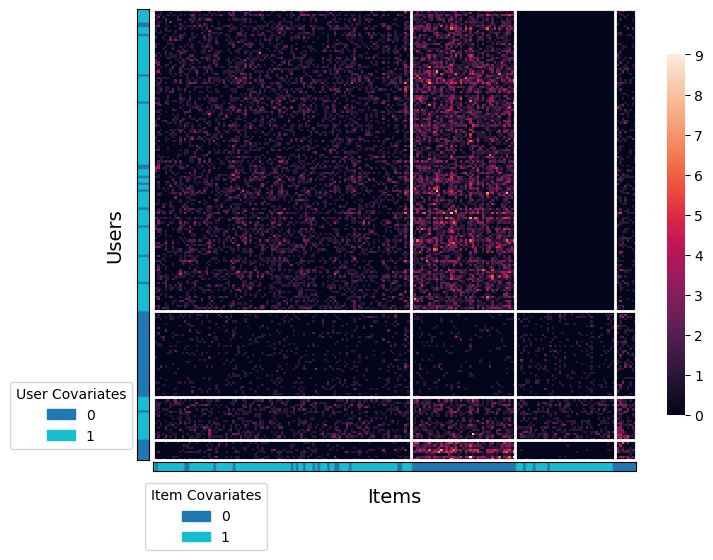

In [6]:
plot_heatmap(model, size=(8,6), user_covariates = model.cov_values_users[0], item_covariates=model.cov_values_items[0], add_labels=False)

### Generate validation set

In [7]:
def generate_val_set(y, size=0.1, seed=42, only_observed=True):
    np.random.seed(seed)
    n_users, n_items = y.shape
    n_val = int(size*n_users*n_items)
    y_val = []
    for _ in range(n_val):
        u = np.random.randint(n_users)
        i = np.random.randint(n_items)
        if only_observed:
            while y[u,i] == 0:
                u = np.random.randint(n_users)
                i = np.random.randint(n_items)
        y_val.append((u,i, int(y[u,i])))
    
    y_train = y.copy()
    for u,i, _ in y_val:
        y_train[u,i] = 0
    
    return y_train, y_val

In [8]:
Y_train, Y_val = generate_val_set(model.Y, size=0.2, seed=42, only_observed=False)

In [9]:
np.save('train_dt.npy', Y_train)
np.save('val_dt.npy', Y_val)
np.save('full_dt.npy', model.Y)

In [10]:
np.save('cov_users.npy', model.cov_values_users[0])
np.save('cov_items.npy', model.cov_values_items[0])

In [11]:
Y_train.shape

(200, 200)

In [12]:
def validate_models(Y_train, Y_val, model_list, param_list, n_iters=500, burn_in=None, verbose=0,
                    thinning=3, model_names=None, true_users=None, true_items=None, k=None,
                    print_intermid=False):
    if burn_in is None:
        burn_in = n_iters//2
    
    Y_val_pairs = [(u,i) for u,i,_ in Y_val]
    Y_val_users = [u for u,_,_ in Y_val]
    Y_val_items = [i for _,i,_ in Y_val]
    Y_val_ratings = [r for _,_,r in Y_val]
    
    
    val_users_relevant = {}

    for j in range(len(Y_val_pairs)):
        u = Y_val_users[j]
        i = Y_val_items[j]
        r = Y_val_ratings[j]
        if u not in val_users_relevant:
            val_users_relevant[u] = [] 
        if r > 1:
            val_users_relevant[u].append(i)
    
    val_users_unique = list(val_users_relevant.keys())
    
    model_list_out = []
    
    for i in range(len(model_list)):
        if model_names is not None:
            name = model_names[i]
        else:
            name = i
            
        print('\nModel name:', name)
            
        model_type = model_list[i]
        params = param_list[i]
        model = model_type(Y=Y_train, num_users=Y_train.shape[0], num_items=Y_train.shape[1], **params)
        print('Starting training for model', name)
        llk_model, user_cl_model, item_cl_model = model.gibbs_train(n_iters, verbose=verbose)
        model_est_users, model_est_items, model_vi_users, model_vi_items = model.estimate_cluster_assignment_vi(burn_in=burn_in, thinning=thinning)
        
        waic_model = None
        
        
        print('Starting waic computation', name)        
        llk_edges = []
        # for iter in range(burn_in, model.n_iters, thinning):
        #     llk_edges.append(model.compute_llk(iter))
        # waic_model = waic_calculation(np.array(llk_edges))
        
        print('Starting prediction for model', name)
        model_ratings = model.point_predict(Y_val_pairs, seed=42)
        mae_model = mean_absolute_error(Y_val_ratings, model_ratings)
        mse_model = mean_squared_error(Y_val_ratings, model_ratings)    
        
        print('Starting ranking for model', name)
        if k is None:
            ranks_model = model.predict_with_ranking(val_users_unique)
        else:
            ranks_model = model.predict_k(val_users_unique, k=k)
            
        precision_list_model = []   
        recall_list_model = []
        for j in range(len(val_users_unique)):
            if len(val_users_relevant[val_users_unique[j]]) == 0:
                continue
            precision_list_model.append(compute_precision(val_users_relevant[val_users_unique[j]], ranks_model[j]))
            recall_list_model.append(compute_recall(val_users_relevant[val_users_unique[j]], ranks_model[j]))
        precision_model = sum(precision_list_model)/len(precision_list_model)
        recall_model = sum(recall_list_model)/len(recall_list_model)
        
        if true_users is not None:
            vi_users_model = VI(true_users, model.user_clustering)[0]
            model.vi_users = vi_users_model
        if true_items is not None:
            vi_items_model = VI(true_items, model.item_clustering)[0]
            model.vi_items = vi_items_model
        
        model.precision_ranks = precision_model
        model.recall_ranks = recall_model
        model.mae = mae_model
        model.mse = mse_model
        model.waic = waic_model
        model.llk_edges = llk_edges
        
        if print_intermid is True:
            print('MAE:', mae_model)
            print('MSE:', mse_model)
            print('Precision:', precision_model)
            print('Recall:', recall_model)
            if true_users is not None:
                print('VI users:', vi_users_model)
            if true_items is not None:
                print('VI items:', vi_items_model)
            if waic_model is not None:
                print('WAIC:', waic_model)
        
        model_list_out.append(model)
        
    return model_list_out

In [13]:
Y_val_pairs = [(x[0], x[1]) for x in Y_val]
Y_val_users = [x[0] for x in Y_val]
Y_val_items = [x[1] for x in Y_val]
Y_val_ratings = [x[2] for x in Y_val]

In [14]:
val_users_relevant = {}

for j in range(len(Y_val_pairs)):
    u = Y_val_users[j]
    i = Y_val_items[j]
    r = Y_val_ratings[j]
    if u not in val_users_relevant:
        val_users_relevant[u] = [] 
    if r > 1:
        val_users_relevant[u].append(i)

## Degree-corrected models

In [15]:
burn_in = 2000
thinning = 2
n_iters = 4000
k = 10

true_users = model.user_clustering.copy()
true_items = model.item_clustering.copy()

In [16]:
params_baseline = {'cov_users':None,'cov_items':None, 'prior_a':1, 'prior_b':1, 'seed':42, 'bar_h_users':2, 'bar_h_items':3,
           'scheme_param':1, 'gamma':0.1, 'epsilon':1e-30, 'sigma':0.7, 'alpha_c':[1.5, 1.5, 1.5, 1.5]}#, 'user_clustering':'random', 'item_clustering':'random'}

params_dp = params_baseline.copy()

params_dp['prior_a'] = 1
params_dp['prior_b'] = 1
params_dp['degree_param_users'] = 2
params_dp['degree_param_items'] = 2
params_dp['scheme_param'] = 2
params_dp['sigma'] = 0.329
params_dp['scheme_type'] = 'DP'

params_py = params_baseline.copy()
params_py['prior_a'] = 1
params_py['prior_b'] = 1
params_py['degree_param_users'] = 2
params_py['degree_param_items'] = 2
params_py['scheme_param'] = 1.3
params_py['sigma'] = 0.1
params_py['scheme_type'] = 'PY'

params_gn = params_baseline.copy()
params_gn['prior_a'] = 1
params_gn['prior_b'] = 1
params_gn['degree_param_users'] = 2
params_gn['degree_param_items'] = 2
params_gn['gamma'] = 0.55
params_gn['scheme_type'] = 'GN'

params_dp_cov = params_baseline.copy()
params_dp_cov['prior_a'] = 1
params_dp_cov['prior_b'] = 1
params_dp_cov['degree_param_users'] = 2
params_dp_cov['degree_param_items'] = 2
params_dp_cov['scheme_param'] = 2
params_dp_cov['cov_users'] = cov_users
params_dp_cov['cov_items'] = cov_items
params_dp_cov['scheme_type'] = 'DP'

params_py_cov = params_baseline.copy()
params_py_cov['prior_a'] = 1
params_py_cov['prior_b'] = 1
params_py_cov['degree_param_users'] = 2
params_py_cov['degree_param_items'] = 2
params_py_cov['scheme_param'] = 1.3
params_py_cov['sigma'] = 0.1
params_py_cov['cov_users'] = cov_users
params_py_cov['cov_items'] = cov_items
params_py_cov['scheme_type'] = 'PY'

params_gn_cov = params_baseline.copy()
params_gn_cov['prior_a'] = 1
params_gn_cov['prior_b'] = 1
params_gn_cov['degree_param_users'] = 2
params_gn_cov['degree_param_items'] = 2
params_gn_cov['gamma'] = 0.55
params_gn_cov['cov_users'] = cov_users
params_gn_cov['cov_items'] = cov_items
params_gn_cov['scheme_type'] = 'GN'

model_list = [dcesbm, dcesbm, dcesbm, dcesbm, dcesbm, dcesbm]
params_list = [params_dp, params_py, params_gn, params_dp_cov, params_py_cov, params_gn_cov]
model_names = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']


In [17]:
out_models_dc = validate_models(Y_train, Y_val, model_list, params_list, n_iters=n_iters, burn_in=burn_in, k = k, verbose=1,
                                thinning=thinning, model_names=model_names, true_users=true_users, true_items=true_items,
                                print_intermid=True)


Model name: DP
Starting training for model DP
starting log likelihood -34232.09429665616
0 -24583.07248268766
time 3.740626096725464
400 -24019.742718026828
time 10.447726011276245
800 -24015.18574987878
time 10.338350296020508
1200 -24014.32225993854
time 9.773669958114624
1600 -24014.863212129203
time 9.722476243972778
2000 -24016.59531520422
time 9.672798156738281
2400 -24021.918938444604
time 9.745353937149048
2800 -24023.330367128405
time 10.30943250656128
3200 -24035.912436157872
time 9.674097537994385
3600 -24019.822181072097
time 9.740424156188965
end llk:  -24022.63456928693
Starting waic computation DP
Starting prediction for model DP
Starting ranking for model DP
MAE: 0.4716858656206758
MSE: 0.5291398500160645
Precision: 0.23450292397660819
Recall: 0.418674575911418
VI users: 0.1884518325880234
VI items: 0.07531503064537293

Model name: PY
Starting training for model PY
starting log likelihood -34232.09429665616
0 -24599.073998550197
time 1.0510354042053223
400 -24020.69509

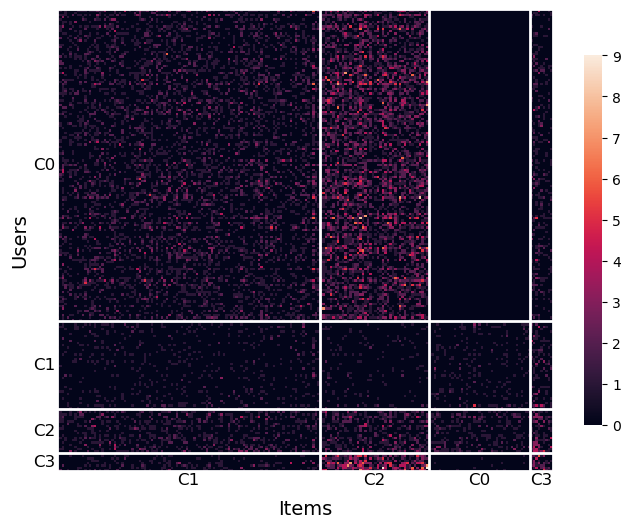

In [18]:
plot_heatmap(out_models_dc[0], size=(8,6))

In [19]:
model_dp = out_models_dc[0]
model_py = out_models_dc[1]
model_gn = out_models_dc[2]
model_dp_cov = out_models_dc[3]
model_py_cov = out_models_dc[4]
model_gn_cov = out_models_dc[5]

In [20]:
import pickle

with open('trained_models/model_dp_dc.pkl', 'wb') as f:
    pickle.dump(model_dp, f)

with open('trained_models/model_py_dc.pkl', 'wb') as f:
    pickle.dump(model_py, f)

with open('trained_models/model_gn_dc.pkl', 'wb') as f:
    pickle.dump(model_gn, f)

with open('trained_models/model_dp_cov_dc.pkl', 'wb') as f:
    pickle.dump(model_dp_cov, f)

with open('trained_models/model_py_cov_dc.pkl', 'wb') as f:
    pickle.dump(model_py_cov, f)

with open('trained_models/model_gn_cov_dc.pkl', 'wb') as f:
    pickle.dump(model_gn_cov, f)

In [34]:
Y_val_pairs = [(u,i) for u,i,_ in Y_val]
Y_val_users = [u for u,_,_ in Y_val]
Y_val_items = [i for _,i,_ in Y_val]
Y_val_ratings = [r for _,_,r in Y_val]


val_users_relevant = {}

for j in range(len(Y_val_pairs)):
    u = Y_val_users[j]
    i = Y_val_items[j]
    r = Y_val_ratings[j]
    if u not in val_users_relevant:
        val_users_relevant[u] = [] 
    if r > 1:
        val_users_relevant[u].append(i)

val_users_unique = list(val_users_relevant.keys())

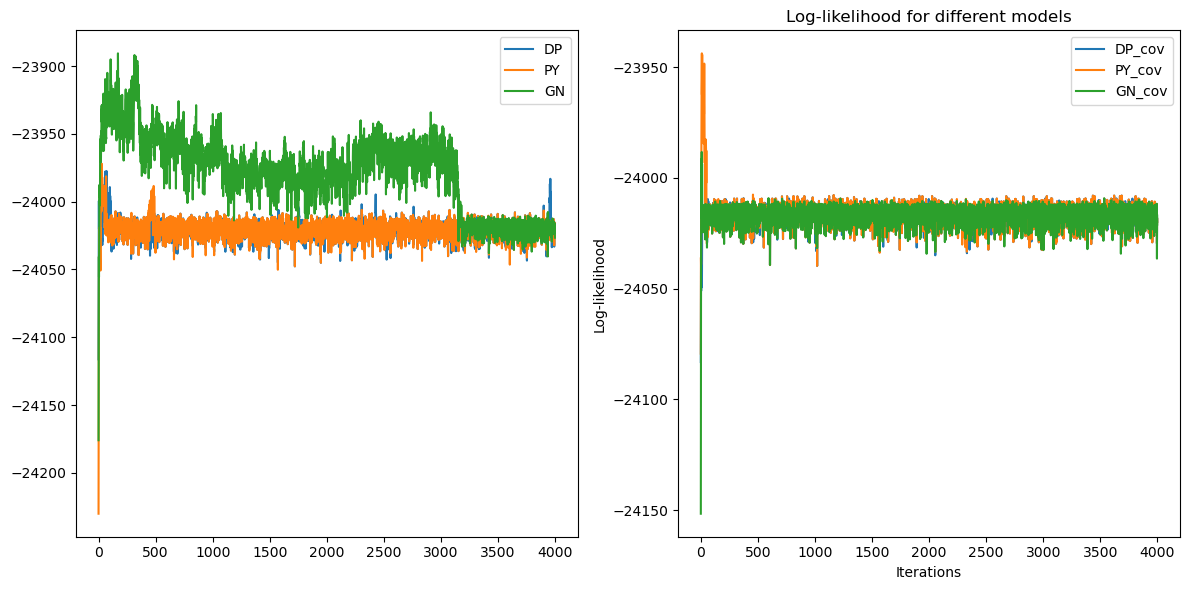

In [21]:
llk_dp = model_dp.train_llk
llk_py = out_models_dc[1].train_llk
llk_gn = out_models_dc[2].train_llk

llk_dp_cov = out_models_dc[3].train_llk
llk_py_cov = out_models_dc[4].train_llk
llk_gn_cov = out_models_dc[5].train_llk

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(llk_dp[2:], label='DP')
ax[0].plot(llk_py[2:], label='PY')
ax[0].plot(llk_gn[2:], label='GN')
ax[0].legend()

ax[1].plot(llk_dp_cov[2:], label='DP_cov')
ax[1].plot(llk_py_cov[2:], label='PY_cov')
ax[1].plot(llk_gn_cov[2:], label='GN_cov')
ax[1].legend()

plt.title('Log-likelihood for different models')
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')

plt.tight_layout()
plt.show()

In [48]:
vi_users_dp = model_dp.vi_users
vi_items_dp = model_dp.vi_items
vi_users_py = model_py.vi_users
vi_items_py = model_py.vi_items
vi_users_gn = model_gn.vi_users
vi_items_gn = model_gn.vi_items

vi_users_dp_cov = model_dp_cov.vi_users
vi_items_dp_cov = model_dp_cov.vi_items
vi_users_py_cov = model_py_cov.vi_users
vi_items_py_cov = model_py_cov.vi_items
vi_users_gn_cov = model_gn_cov.vi_users
vi_items_gn_cov = model_gn_cov.vi_items

mae_dp = model_dp.mae
mae_py = model_py.mae
mae_gn = model_gn.mae

mae_dp_cov = model_dp_cov.mae
mae_py_cov = model_py_cov.mae
mae_gn_cov = model_gn_cov.mae

mse_dp = model_dp.mse
mse_py = model_py.mse
mse_gn = model_gn.mse

mse_dp_cov = model_dp_cov.mse
mse_py_cov = model_py_cov.mse
mse_gn_cov = model_gn_cov.mse

waic_dp = model_dp.waic
waic_py = model_py.waic
waic_gn = model_gn.waic

waic_dp_cov = model_dp_cov.waic
waic_py_cov = model_py_cov.waic
waic_gn_cov = model_gn_cov.waic

precision_dp = model_dp.precision_ranks
precision_py = model_py.precision_ranks
precision_gn = model_gn.precision_ranks

precision_dp_cov = model_dp_cov.precision_ranks
precision_py_cov = model_py_cov.precision_ranks
precision_gn_cov = model_gn_cov.precision_ranks

recall_dp = model_dp.recall_ranks
recall_py = model_py.recall_ranks
recall_gn = model_gn.recall_ranks

recall_dp_cov = model_dp_cov.recall_ranks
recall_py_cov = model_py_cov.recall_ranks
recall_gn_cov = model_gn_cov.recall_ranks

In [49]:
output_table = pd.DataFrame()
output_table['VI users'] = [vi_users_dp, vi_users_py, vi_users_gn, vi_users_dp_cov, vi_users_py_cov, vi_users_gn_cov]
output_table['VI items'] = [vi_items_dp, vi_items_py, vi_items_gn, vi_items_dp_cov, vi_items_py_cov, vi_items_gn_cov]
output_table['MAE'] = [mae_dp, mae_py, mae_gn, mae_dp_cov, mae_py_cov, mae_gn_cov]
output_table['MSE'] = [mse_dp, mse_py, mse_gn, mse_dp_cov, mse_py_cov, mse_gn_cov]
output_table['WAIC'] = [waic_dp, waic_py, waic_gn, waic_dp_cov, waic_py_cov, waic_gn_cov]
output_table['Precision'] = [precision_dp, precision_py, precision_gn, precision_dp_cov, precision_py_cov, precision_gn_cov]
output_table['Recall'] = [recall_dp, recall_py, recall_gn, recall_dp_cov, recall_py_cov, recall_gn_cov]

output_table.index = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']
output_table.round(3)

,VI users,VI items,MAE,MSE,WAIC,Precision,Recall
DP,0.188,0.075,0.472,0.529,None,0.235,0.419
PY,0.188,0.075,0.472,0.529,None,0.235,0.419
GN,0.188,0.000,0.472,0.529,None,0.235,0.419
DP_cov,0.127,0.000,0.472,0.529,None,0.235,0.419
PY_cov,0.127,0.000,0.472,0.529,None,0.235,0.419
GN_cov,0.127,0.000,0.472,0.529,None,0.235,0.419


## Non dc model

In [24]:
burn_in = 4000
thinning = 5
n_iters = 8000
k = 10

true_users = model.user_clustering.copy()
true_items = model.item_clustering.copy()

In [25]:
params_baseline = {'cov_users':None,'cov_items':None, 'prior_a':1, 'prior_b':1, 'seed':42, 'scheme_param':1, 'bar_h_users':2, 'bar_h_items':3,
           'gamma':0.1, 'epsilon':1e-30, 'sigma':0.7, 'alpha_c':[1.5, 1.5, 1.5, 1.5]}

params_dp = params_baseline.copy()

params_dp['prior_a'] = 1
params_dp['prior_b'] = 1
params_dp['scheme_param'] = 2
params_dp['sigma'] = 0.329
params_dp['scheme_type'] = 'DP'

params_py = params_baseline.copy()
params_py['prior_a'] = 1
params_py['prior_b'] = 1
params_py['scheme_param'] = 1.3
params_py['sigma'] = 0.1
params_py['scheme_type'] = 'PY'

params_gn = params_baseline.copy()
params_gn['prior_a'] = 1
params_gn['prior_b'] = 1
params_gn['gamma'] = 0.55
params_gn['scheme_type'] = 'GN'

params_dp_cov = params_baseline.copy()
params_dp_cov['prior_a'] = 1
params_dp_cov['prior_b'] = 1
params_dp_cov['scheme_param'] = 2
params_dp_cov['cov_users'] = cov_users
params_dp_cov['cov_items'] = cov_items
params_dp_cov['scheme_type'] = 'DP'

params_py_cov = params_baseline.copy()
params_py_cov['prior_a'] = 1
params_py_cov['prior_b'] = 1
params_py_cov['scheme_param'] = 1.3
params_py_cov['sigma'] = 0.1
params_py_cov['cov_users'] = cov_users
params_py_cov['cov_items'] = cov_items
params_py_cov['scheme_type'] = 'PY'

params_gn_cov = params_baseline.copy()
params_gn_cov['prior_a'] = 1
params_gn_cov['prior_b'] = 1
params_gn_cov['gamma'] = 0.55
params_gn_cov['cov_users'] = cov_users
params_gn_cov['cov_items'] = cov_items
params_gn_cov['scheme_type'] = 'GN'

model_list = [esbm, esbm, esbm, esbm, esbm, esbm]
params_list = [params_dp, params_py, params_gn, params_dp_cov, params_py_cov, params_gn_cov]
model_names = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']

In [26]:
out_models = validate_models(Y_train, Y_val, model_list, params_list, n_iters=n_iters, burn_in=burn_in, k = k,
                                thinning=thinning, model_names=model_names, true_users=true_users, true_items=true_items)


Model name: DP
Starting training for model DP
starting log likelihood -34232.09429665616
end llk:  -23773.915871623172
Starting waic computation DP
Starting prediction for model DP
Starting ranking for model DP

Model name: PY
Starting training for model PY
starting log likelihood -34232.09429665616
end llk:  -23805.671314443483
Starting waic computation PY
Starting prediction for model PY
Starting ranking for model PY

Model name: GN
Starting training for model GN
starting log likelihood -34232.09429665616
end llk:  -23786.969718239918
Starting waic computation GN
Starting prediction for model GN
Starting ranking for model GN

Model name: DP_cov
Starting training for model DP_cov
starting log likelihood -34232.09429665616
end llk:  -23801.78155643055
Starting waic computation DP_cov
Starting prediction for model DP_cov
Starting ranking for model DP_cov

Model name: PY_cov
Starting training for model PY_cov
starting log likelihood -34232.09429665616
end llk:  -23811.868770909976
Start

In [27]:
model_dp_esbm = out_models[0]
model_py_esbm = out_models[1]
model_gn_esbm = out_models[2]
model_dp_cov_esbm = out_models[3]
model_py_cov_esbm = out_models[4]
model_gn_cov_esbm = out_models[5]

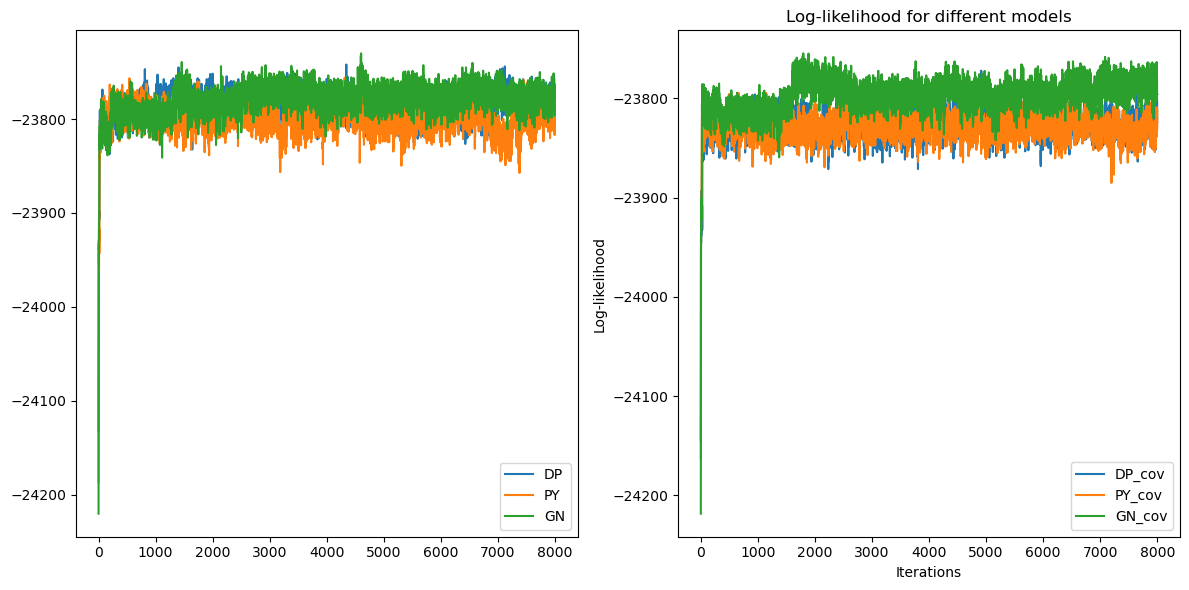

In [28]:
llk_dp = model_dp_esbm.train_llk
llk_py = model_py_esbm.train_llk
llk_gn = model_gn_esbm.train_llk

llk_dp_cov = model_dp_cov_esbm.train_llk
llk_py_cov = model_py_cov_esbm.train_llk
llk_gn_cov = model_gn_cov_esbm.train_llk

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(llk_dp[2:], label='DP')
ax[0].plot(llk_py[2:], label='PY')
ax[0].plot(llk_gn[2:], label='GN')
ax[0].legend()

ax[1].plot(llk_dp_cov[2:], label='DP_cov')
ax[1].plot(llk_py_cov[2:], label='PY_cov')
ax[1].plot(llk_gn_cov[2:], label='GN_cov')
ax[1].legend()

plt.title('Log-likelihood for different models')
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')

plt.tight_layout()
plt.show()

In [ ]:
vi_users_dp = model_dp_esbm.vi_users
vi_items_dp = model_dp_esbm.vi_items
vi_users_py = model_py_esbm.vi_users
vi_items_py = model_py_esbm.vi_items
vi_users_gn = model_gn_esbm.vi_users
vi_items_gn = model_gn_esbm.vi_items

vi_users_dp_cov = model_dp_cov_esbm.vi_users
vi_items_dp_cov = model_dp_cov_esbm.vi_items
vi_users_py_cov = model_py_cov_esbm.vi_users
vi_items_py_cov = model_py_cov_esbm.vi_items
vi_users_gn_cov = model_gn_cov_esbm.vi_users
vi_items_gn_cov = model_gn_cov_esbm.vi_items


mae_dp = model_dp_esbm.mae
mae_py = model_py_esbm.mae
mae_gn = model_gn_esbm.mae
mae_dp_cov = model_dp_cov_esbm.mae
mae_py_cov = model_py_cov_esbm.mae
mae_gn_cov = model_gn_cov_esbm.mae

mse_dp = model_dp_esbm.mse
mse_py = model_py_esbm.mse
mse_gn = model_gn_esbm.mse
mse_dp_cov = model_dp_cov_esbm.mse
mse_py_cov = model_py_cov_esbm.mse
mse_gn_cov = model_gn_cov_esbm.mse

precision_dp = model_dp_esbm.precision_ranks
precision_py = model_py_esbm.precision_ranks
precision_gn = model_gn_esbm.precision_ranks
precision_dp_cov = model_dp_cov_esbm.precision_ranks
precision_py_cov = model_py_cov_esbm.precision_ranks
precision_gn_cov = model_gn_cov_esbm.precision_ranks
recall_dp = model_dp_esbm.recall_ranks
recall_py = model_py_esbm.recall_ranks
recall_gn = model_gn_esbm.recall_ranks
recall_dp_cov = model_dp_cov_esbm.recall_ranks
recall_py_cov = model_py_cov_esbm.recall_ranks
recall_gn_cov = model_gn_cov_esbm.recall_ranks

In [30]:
output_table2 = pd.DataFrame()

output_table2['VI users'] = [vi_users_dp, vi_users_py, vi_users_gn, vi_users_dp_cov, vi_users_py_cov, vi_users_gn_cov]
output_table2['VI items'] = [vi_items_dp, vi_items_py, vi_items_gn, vi_items_dp_cov, vi_items_py_cov, vi_items_gn_cov]
output_table2['MAE'] = [mae_dp, mae_py, mae_gn, mae_dp_cov, mae_py_cov, mae_gn_cov]
output_table2['MSE'] = [mse_dp, mse_py, mse_gn, mse_dp_cov, mse_py_cov, mse_gn_cov]
output_table2['Precision'] = [precision_dp, precision_py, precision_gn, precision_dp_cov, precision_py_cov, precision_gn_cov]
output_table2['Recall'] = [recall_dp, recall_py, recall_gn, recall_dp_cov, recall_py_cov, recall_gn_cov]

output_table2.index = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']
output_table2.round(3)

,VI users,VI items,MAE,MSE,Precision,Recall
DP,1.518,1.299,0.484,0.550,0.223,0.398
PY,1.532,1.336,0.481,0.546,0.218,0.377
GN,1.666,1.191,0.480,0.545,0.213,0.372
DP_cov,1.287,1.256,0.480,0.546,0.225,0.409
PY_cov,1.291,1.218,0.480,0.546,0.225,0.401
GN_cov,1.517,1.222,0.481,0.543,0.227,0.410


In [31]:
output_table.round(3)

,VI users,VI items,MAE,MSE,WAIC,Precision,Recall
DP,0.188,0.075,0.472,0.529,None,0.235,0.419
PY,0.188,0.075,0.472,0.529,None,0.235,0.419
GN,0.188,0.000,0.472,0.529,None,0.235,0.419
DP_cov,0.127,0.000,0.472,0.529,None,0.235,0.419
PY_cov,0.127,0.000,0.472,0.529,None,0.235,0.419
GN_cov,0.127,0.000,0.472,0.529,None,0.235,0.419


In [32]:
import pickle

with open('trained_models/model_dp_esbm.pkl', 'wb') as f:
    pickle.dump(model_dp, f)

with open('trained_models/model_py_esbm.pkl', 'wb') as f:
    pickle.dump(model_py, f)

with open('trained_models/model_gn_esbm.pkl', 'wb') as f:
    pickle.dump(model_gn, f)

with open('trained_models/model_dp_cov_esbm.pkl', 'wb') as f:
    pickle.dump(model_dp_cov, f)

with open('trained_models/model_py_cov_esbm.pkl', 'wb') as f:
    pickle.dump(model_py_cov, f)

with open('trained_models/model_gn_cov_esbm.pkl', 'wb') as f:
    pickle.dump(model_gn_cov, f)

from the next cell it is clear that the issue of flat esbm is that it tends to cluster based on degree 

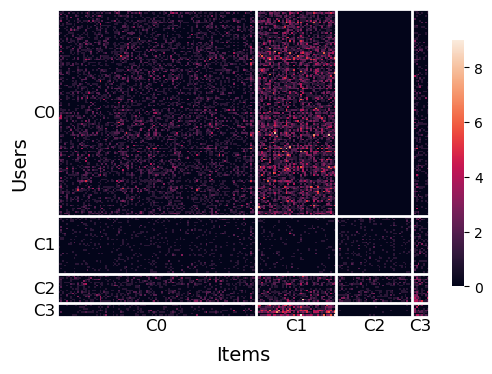

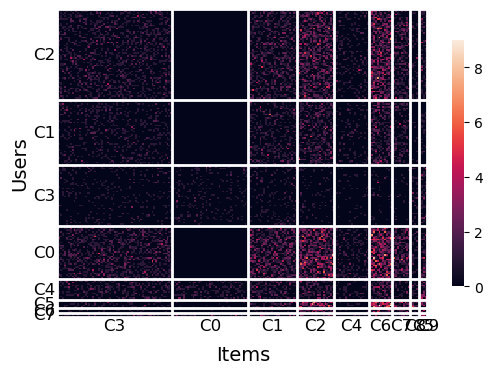

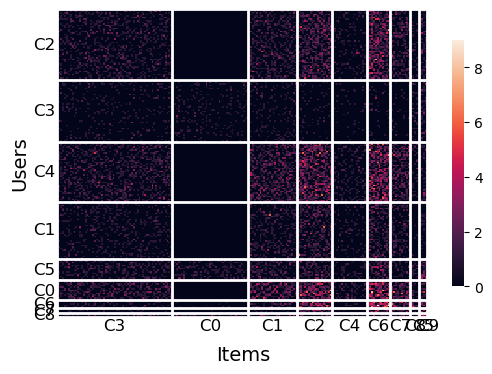

(None, None, None)

In [33]:
plot_heatmap(model, size=(6,4)), plot_heatmap(model_py_cov_esbm, size=(6,4)), plot_heatmap(model_gn_cov_esbm, size=(6,4))